In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### 1 为什么要选择加入注意力方式在backbone中：  
在 scSE论文中发现（s代表的是spatial, c代表的channel) 在卷积后加入scSE模块可以有效的增强有意义的特征，提高无意义的特征，并且在两个医疗数据集中取得了很好的效果。在unet中可以添加到encoder或者decoder的部分，对于decoder的信息部分进行提炼。  
### 2 cSE结构如图所示 过程 全局池化+压缩舒张+sigmoid后相乘
![cse结构](https://img-blog.csdnimg.cn/20200603095939227.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2p1c3Rzb2xvdw==,size_16,color_FFFFFF,t_70)

In [8]:
class cSEBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.squeeze = nn.Conv2d(in_channels, in_channels//2, kernel_size=1,bias=False)
        self.expand = nn.Conv2d(in_channels//2, in_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        '''input : [bs, c, w, h] '''
        x = inputs
        x = self.avgpool(x)
        x = self.sigmoid(self.expand(self.squeeze(x)))
        return x * inputs

### 3 sSE模块 过程直接输出channel唯一的featuremap 然后直接sigmoid相乘  
![sSE module](https://img-blog.csdnimg.cn/20200603100402128.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2p1c3Rzb2xvdw==,size_16,color_FFFFFF,t_70)

In [41]:
class sSEBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        x = inputs
        x = self.sigmoid(self.conv(x))
        return x*inputs

### 4 scse整体的模块： 
![1](https://img-blog.csdnimg.cn/20200603100612339.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2p1c3Rzb2xvdw==,size_16,color_FFFFFF,t_70)

In [42]:
class scSEblock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.cSE = cSEBlock(in_channels)
        self.sSE = sSEBlock(in_channels)
    def forward(self, inputs):
        x1 = self.cSE(inputs)
        x2 = self.sSE(inputs)
        return x1 + x2

In [43]:
test = torch.rand(4,256,24,24)
a = scSEblock(256)
a(test).shape

torch.Size([4, 256, 24, 24])

### 5 cbam与bam与csSE的区别  
cbam两个模块 关注在了max avg的部分。  
在channel attention module的部分，分别进行了全局平均池化和全局最大池化，分别对两个进行压缩舒张操作，之后相加经过sigmoid得到了最后的结果。  
![cam](https://pic2.zhimg.com/80/v2-8fefab2340c4a045f77ad35501717e89_720w.jpg)  
在spatial attention module的部分，最每个channel进行全局池化和平均池化，然后将两者concat进行conv成一层featuremap之后sigmoid得到最后的空间注意力的特征层  
![sam](https://pic3.zhimg.com/80/v2-c023d0d068bca35204040fe4025471da_720w.jpg)  
CBAM则是两者的串联结构，BAM则是两者的并联结构。他们相对与csSE都会更加复杂的，注意在max和avg这两个特征上面。
![cbam](https://pic3.zhimg.com/80/v2-c023d0d068bca35204040fe4025471da_720w.jpg)
BAM channel注意力与SE相同，但sptial像resnet，先压缩维度，再3x3再变成一个featuremap，再与channel attention结合经过sigmoid之后再与input相乘，再残差相加得到最后的结果。  
![cbm](https://img-blog.csdnimg.cn/20201222185120636.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3NoYW5nbGlhbmxt,size_16,color_FFFFFF,t_70)

In [45]:
class ChannelAttentionModule(nn.Module):
    def __init__(self, in_channel, reduction):
        super().__init__()
        self.global_maxpool = nn.AdaptiveMaxPool2d(1)
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channel, in_channel//reduction, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channel//reduction, in_channel, kernel_size=1, bias=False),
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        x1 = self.global_maxpool(inputs)
        x2 = self.global_avgpool(inputs)
        x1 = self.fc(x1)
        x2 = self.fc(x2)
        x = self.sigmoid(x1+x2)
        return x * inputs
    
class SpatialAttentionModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        # torch.max 返回第一个是最大的数，第二个是所在索引
        x1,_ = torch.max(inputs, dim=1, keepdim=True)
        x2 = torch.mean(inputs, dim=1, keepdim=True)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        x = self.sigmoid(x)
        return x * inputs
    
class CBAM(nn.Module):
    def __init__(self, in_channel, reduction):
        super().__init__()
        self.cam = ChannelAttentionModule(in_channel, reduction)
        self.sam = SpatialAttentionModule()
    def forward(self, inputs):
        x = self.cam(inputs)
        x = self.sam(x)
        return x


### sknet
相比叫senet多了一个或多个并行的通道 3x3 和 5x5
再加和成为U的时候多一个维度,这里的softmax一定注意，是对a，b这两个向量对应的channel，也就是说我们再一个通道上更关注上面还是下面。（这里很妙)
![sknet](https://img-blog.csdnimg.cn/20190406100155584.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3F3ZWRzYWV3cQ==,size_16,color_FFFFFF,t_70)

In [72]:
class SKConv(nn.Module):
    def __init__(self, feature, M, L):
        '''M控制分成几条支路 L控制压缩维度'''
        super().__init__()
        self.M = M
        self.feature = feature
        self.convs = nn.ModuleList([])
        for i in range(self.M):
            self.convs.append(
                nn.Sequential(
                    nn.Conv2d(feature, feature, 3+i*2, padding=i, bias=False),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=False)))
        self.fc = nn.Linear(feature, L)
        self.fcs = nn.ModuleList([])
        for i in range(self.M):
            self.fcs.append(nn.Linear(L, feature))
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        for i, conv in enumerate(self.convs):
            # 扩充一个维度进行相加
            fea = conv(x).unsqueeze_(1) # bs 1 c w h
            if i == 0:
                feas = fea
            else:
                feas = torch.cat([feas, fea], dim=1) # bs +1 c w h 
        fea_u = torch.sum(feas, dim=1) # bs c w h
        fea_s = fea_u.mean(-1).mean(-1) # bs c
        fea_z = self.fc(fea_s)  # bs l
        for i, fc in enumerate(self.fcs):
            vector = fc(fea_z).unsqueeze_(dim=1) # bs 1 c
            if i == 0:
                attention_vectors = vector
            else:
                attention_vectors = torch.cat([attention_vectors, vector],
                                              dim=1)
        attention_vectors = self.softmax(attention_vectors)
        # 这里求更关注上面还是下面的这featuremap中的一个通道
        attention_vectors = attention_vectors.unsqueeze(-1).unsqueeze(-1)
        fea_v = (feas * attention_vectors).sum(dim=1)
        return fea_v
        

### 6 eca net 更加有效的注意力方式
之前的注意力都没有加入到通道方向上的融合，这里可以将多个进行融合。
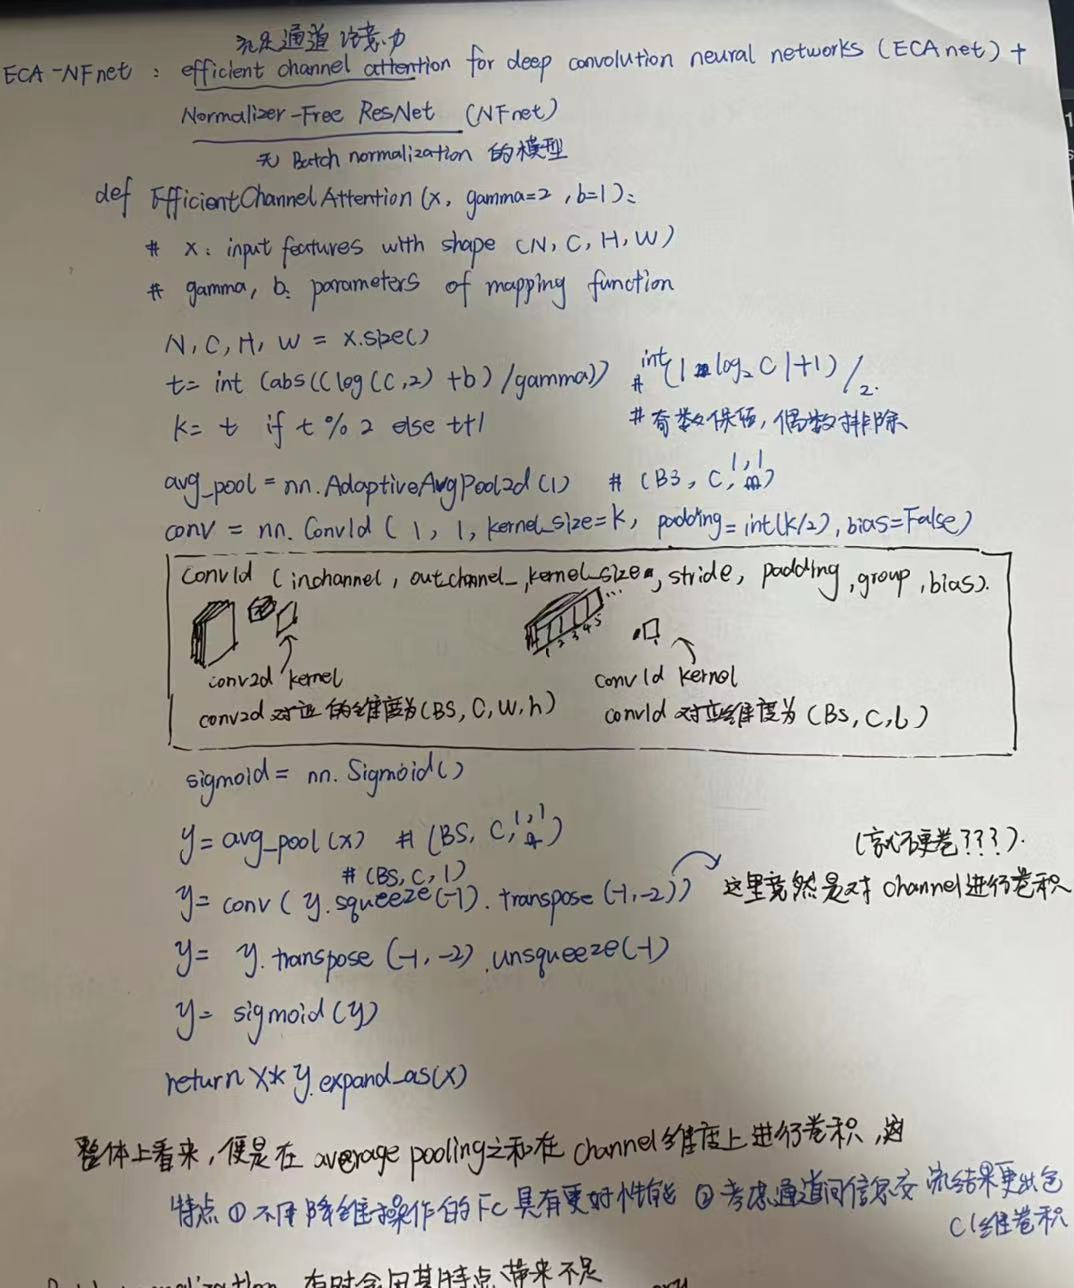